# Overview

I'm going to take a trained model, e.g., the "super-converged" resnet34 weights, and try to make predictions on grayscale images. Note that images can be grayscale for two reasons:
1. only a single photometric band is available
2. a very wide band (combination of photometric bands) image has been averaged together

In practice the first option is probably more common. Optical morphology is often distinguished on the basis of $r$-band imaging alone (see, e.g., [Kannappan, Guie, & Baker 2009](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:0903.3695)).

# Imports and helper functions

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

In [4]:
train_label_csv = f'{PATH}/catalogs/train-metaldist.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [5]:
sz = 128
bs = 512
arch = resnet34

trn_tfms, val_tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=(trn_tfms, val_tfms),
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=8)

# Load in previous learner (trained on *gri* imaging)

In [103]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

learn.load('resnet34-CLR-init')

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

# Make predictions!

In [118]:
learn.predict()

array([[8.9047 , 8.94521, 8.98178, 9.01745, 9.05461],
       [8.15882, 8.37416, 8.57304, 8.71865, 8.83427],
       [8.73939, 8.77169, 8.80144, 8.8283 , 8.85306],
       ...,
       [8.85019, 8.90388, 8.95325, 9.00064, 9.04852],
       [8.25977, 8.41567, 8.5602 , 8.66741, 8.74917],
       [8.97699, 9.00442, 9.03114, 9.05826, 9.08782]], dtype=float32)

In [104]:
id_numbers = np.array([fname[5:-4] for fname in data.test_ds.fnames], dtype=np.int64)

def retrieve_r_image(obj_id):
    [idx] = np.where(obj_id == id_numbers)[0]
    r_band = data.test_ds.get_x(idx)[:, :, 1]

    return np.stack([r_band, r_band, r_band], axis=2) # make 128x128x3

In [125]:
df_test = pd.read_csv(f'{PATH}/catalogs/test-metaldist.csv', index_col=0)
df_test.head()

,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5
objID,,,,,
1237648672922206684,8.600992,8.644032,8.676655,8.706522,8.729147
1237648673431879906,8.763014,8.829043,8.915661,8.985325,9.059927
1237648673458028997,8.801155,8.808941,8.824834,8.835920,8.848814
1237648673459470810,8.527153,8.568700,8.598277,8.649737,8.696940
1237648673994768731,8.224578,8.344159,8.486758,8.578484,8.660710


oh_p2p5     8.616034
oh_p16      8.664618
oh_p50      8.691298
oh_p84      8.718909
oh_p97p5    8.759433
Name: 1237648720686153859, dtype: float64

array([[8.5568 , 8.6274 , 8.68837, 8.73705, 8.77794]], dtype=float32)

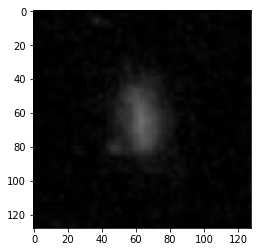

In [129]:
# get test image + answer
obj_id = df_test.index[256]
display(df_test.loc[obj_id])

r_image = retrieve_r_image(obj_id)
plt.imshow(r_image);

# make prediction
pred = learn.predict_array(trn_tfms(r_image)[None])
display(pred)

## Make all grayscale image predictions

**Only using r-band here**

In [131]:
preds = np.zeros((len(df_test), 5))

for idx in tqdm_notebook(range(len(df_test)), total=len(df_test)):
    obj_id = df_test.index[idx]
    preds[idx] = learn.predict_array(trn_tfms(retrieve_r_image(obj_id))[None])


Compare distributions with the truth values...

In [148]:
truths = df_test.values

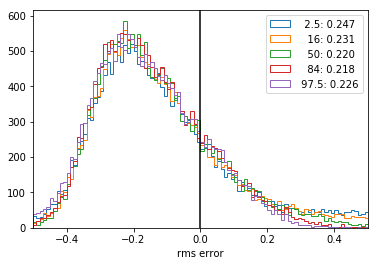

In [147]:
rms_errors = np.sqrt(np.mean((preds - truths)**2, axis=0))

for i in range(5):
    plt.hist(preds[:, i]-truths[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['2.5', '16', '50', '84', '97.5'], rms_errors)]);
plt.xlim(-0.5, 0.5)
plt.axvline(0, c='k')
plt.xlabel('rms error');

Compare this to random shuffling:

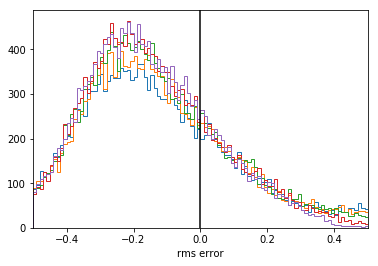

In [154]:
for i in range(5):
    plt.hist(np.random.permutation(preds[:, i])-truths[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.xlim(-0.5, 0.5)
plt.axvline(0, c='k')
plt.xlabel('rms error');

Monochrome images only beats a random permutation by about **0.04 dex** -- or in other words, we're only doing a little bit better using nothing but r-band morphology than by choosing any random r-band SDSS galaxy.

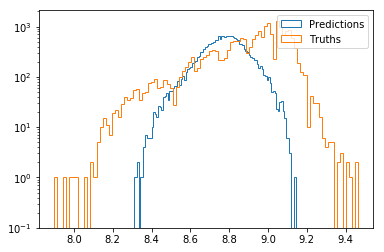

In [153]:
plt.hist(preds[:, 2], log=True, bins=100, histtype='step', label='Predictions')
plt.hist(truths[:, 2], log=True, bins=100, histtype='step', label='Truths')
plt.legend();

# Train on single-color images

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse